In [1]:
!pip install plotly

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json 
from sklearn.metrics import recall_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-11-18 14:46:52.127762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763477212.466101      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763477212.548633      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/kaggle/input/shopify-stock-data-2025/SHOP_2000-05-20_2025-11-17.csv


In [3]:
df = pd.read_csv("/kaggle/input/shopify-stock-data-2025/SHOP_2000-05-20_2025-11-17.csv")
df.head(3)

,date,open,high,low,close,adj_close,volume
0,NaN,SHOP,SHOP,SHOP,SHOP,SHOP,SHOP
1,2015-05-20,1.7000000476837158,1.7000000476837158,1.7000000476837158,1.7000000476837158,1.7000000476837158,0
2,2015-05-21,2.799999952316284,2.874000072479248,2.4110000133514404,2.568000078201294,2.568000078201294,123039000


In [4]:
#remove the incorrect first row 
df=df[df['open'] != 'SHOP'].copy()
#df = df[df[0]].dropna
#convert
df['date'] = pd.to_datetime(df['date'])
df.head(3)

,date,open,high,low,close,adj_close,volume
1,2015-05-20,1.7000000476837158,1.7000000476837158,1.7000000476837158,1.7000000476837158,1.7000000476837158,0
2,2015-05-21,2.799999952316284,2.874000072479248,2.4110000133514404,2.568000078201294,2.568000078201294,123039000
3,2015-05-22,2.6070001125335693,3.109999895095825,2.5999999046325684,2.8310000896453857,2.8310000896453857,28412000


In [5]:
#convert numeric columns
numeric_cols = ['open','high','low','close','adj_close','volume']
for col in numeric_cols:
    df[col]=pd.to_numeric(df[col],errors='coerce')
#sort the order by date
df=df.sort_values('date')
df=df.reset_index(drop=True)
df.head()



,date,open,high,low,close,adj_close,volume
0,2015-05-20,1.700,1.700,1.700,1.700,1.700,0
1,2015-05-21,2.800,2.874,2.411,2.568,2.568,123039000
2,2015-05-22,2.607,3.110,2.600,2.831,2.831,28412000
3,2015-05-26,2.980,3.034,2.908,2.965,2.965,8202000
4,2015-05-27,3.067,3.081,2.700,2.750,2.750,7976000


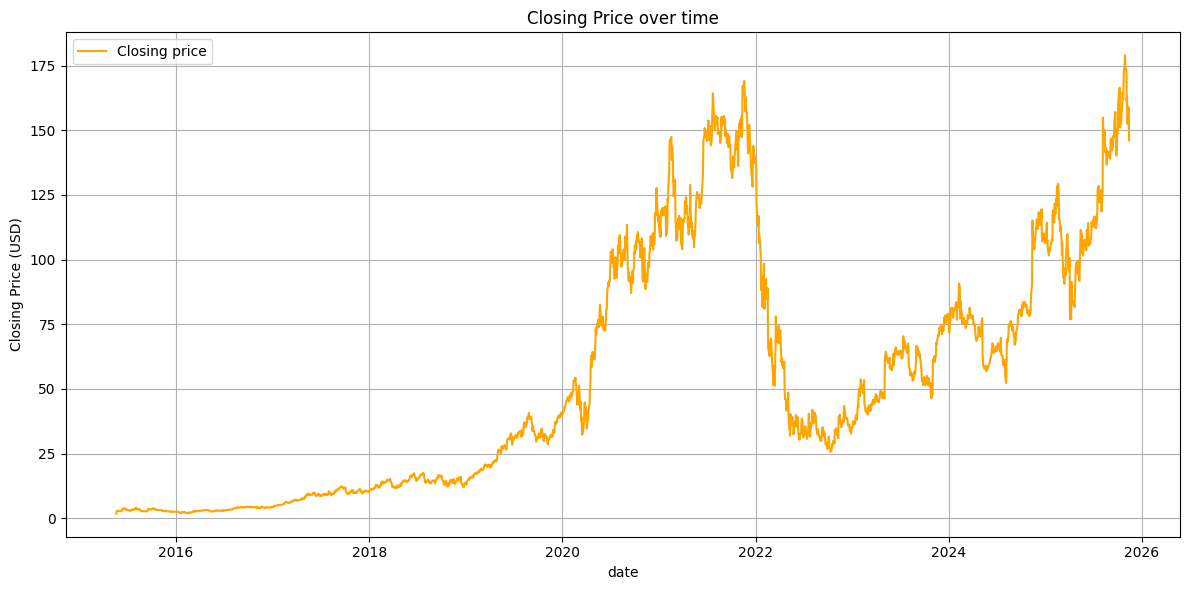

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df['date'],df['close'],label = 'Closing price',color = 'orange')
plt.title("Closing Price over time")
plt.xlabel("date")
plt.ylabel("Closing Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
#add technical indicators
#simple moving Avg
df['SMA_10']= df['close'].rolling(window=10).mean()
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

#EMA : Exponetial moving vg
df['EMA_10'] = df['close'].ewm(span=10 ,adjust=False).mean()
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

#Relative Index Strength (RSI) purpose Momentum & OverBrought/Oversold detection
delta = df['close'].diff()
gain = (delta.where(delta>0,0)).rolling(window =14).mean()
loss = (-delta.where(delta<0,0)).rolling(window =14).mean()
rs = gain/loss
df['RSI_14'] = 100-(100/(1+rs))

#MACD
EMA_12 = df['close'].ewm(span=12,adjust = False).mean()
EMA_26 = df['close'].ewm(span=26,adjust = False).mean()

df['EMA_12'] = df['close'].ewm(span=12,adjust = False).mean()
df['EMA_26'] = df['close'].ewm(span=26,adjust = False).mean()
df['MACD'] = EMA_12-EMA_26
df['MACD_signal'] = df['MACD'].ewm(span=9,adjust=False).mean()

#daily returns 
df['return'] = df['close'].pct_change()
# voliation  7 days  rolling standard deviation

df['voliation'] = df['return'].rolling(window = 7).std()

df.tail()





/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,date,open,high,low,close,adj_close,volume,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,RSI_14,EMA_12,EMA_26,MACD,MACD_signal,return,voliation
2635,2025-11-10,157.115005,159.630005,155.750000,158.880005,158.880005,10493300,166.958002,164.870001,155.945001,162.728765,163.053110,46.591737,163.215329,161.995721,1.219607,3.709270,0.042451,0.036772
2636,2025-11-11,156.830002,160.039993,155.520004,158.940002,158.940002,5344200,164.956001,165.173001,156.343001,162.039899,162.661386,47.188136,162.557586,161.769372,0.788215,3.125059,0.000378,0.036709
2637,2025-11-12,160.110001,160.494003,156.229996,156.589996,156.589996,6585700,162.714001,165.192001,156.670401,161.049008,162.083158,39.946065,161.639495,161.385714,0.253781,2.550803,-0.014785,0.036589
2638,2025-11-13,153.839996,155.000000,143.800003,146.339996,146.339996,11351200,159.987001,164.680500,156.694201,158.374642,160.583809,26.346660,159.285726,160.271217,-0.985490,1.843545,-0.065458,0.035605
2639,2025-11-14,142.330002,149.720001,141.000000,146.039993,146.039993,8379400,157.205000,164.094500,156.678600,156.131979,159.198684,23.346794,157.247921,159.217052,-1.969131,1.081010,-0.002050,0.034298


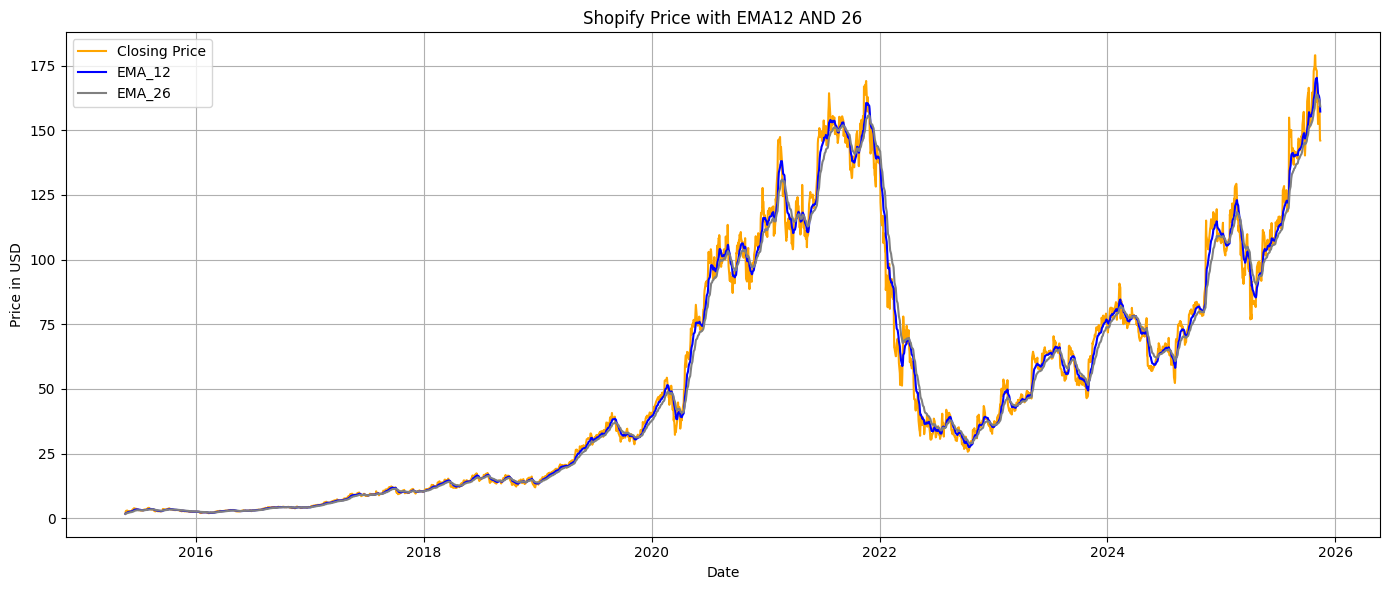

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df['date'],df['close'],label ='Closing Price', color='Orange')
plt.plot(df['date'],df['EMA_12'],label = 'EMA_12',color = 'Blue')
plt.plot(df['date'],df['EMA_26'],label = 'EMA_26',color= 'Grey')

plt.title("Shopify Price with EMA12 AND 26")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=df['close'],
                         mode='lines', name='Closing Price'))
fig.add_trace(go.Scatter(x=df['date'], y=df['EMA_12'],
                         mode='lines', name='EMA 12'))
fig.add_trace(go.Scatter(x=df['date'], y=df['EMA_26'],
                         mode='lines', name='EMA 26'))

fig.update_layout(
    title="Shopify Price with EMA(12) and EMA(26)",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    hovermode="x unified"
)

fig.show()

In [13]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=df['date'], y=df['MACD'],
                          mode='lines', name='MACD'))
fig2.add_trace(go.Scatter(x=df['date'], y=df['MACD_signal'],
                          mode='lines', name='Signal Line'))

fig2.add_trace(go.Scatter(x=df['date'], y=[0]*len(df),
                          mode='lines', name='Zero Line', line=dict(color='black', width=1)))

fig2.update_layout(
    title="MACD and Signal Line",
    xaxis_title="Date",
    yaxis_title="MACD Value",
    hovermode="x unified"
)

fig2.show()


In [14]:
features = ['close', 'EMA_12','EMA_26','RSI_14','MACD','voliation']
# copying the featured list to df frame named df_lstm
df_lstm = df[features].copy()
#removing NAN from the list
df_lstm = df_lstm.dropna()
df_lstm.reset_index()
#scaling (0 to 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

#convert back to df
scaled_df = pd.DataFrame(scaled_data,columns= features, index = df_lstm.index)

data = scaled_df.values
len(data)



2627

In [15]:
#LSTM lookback window
LOOKBACK = 60

X=[]
y= []

data = scaled_df.values
close_prices = scaled_df['close'].values

for i in range(LOOKBACK ,len(data)):
    X.append(data[i-LOOKBACK:i]) #previous 60 days
    y.append(close_prices[i])    #predict next day's close

X = np.array(X)
y = np.array(y)

#Train-test split (80/20)
train_size = int(0.8*len(X))

X_train =X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

#show shapes

X_train.shape,y_train.shape,X_test.shape,y_test.shape

    


((2053, 60, 6), (2053,), (514, 60, 6), (514,))

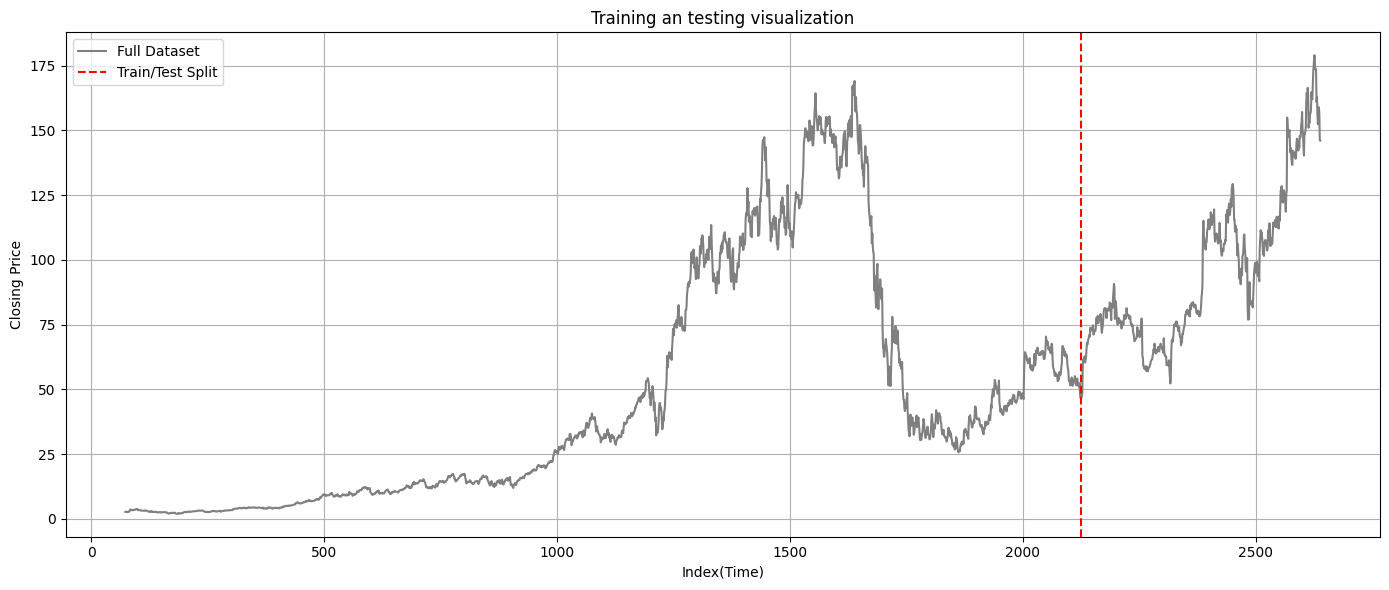

In [16]:
plt.figure(figsize=(14,6))
plt.plot(df_lstm.index[LOOKBACK:], df_lstm['close'].iloc[LOOKBACK:],label= "Full Dataset" , color = 'gray')
plt.axvline(df_lstm.index[LOOKBACK+ train_size],color = 'red',linestyle= '--',label ='Train/Test Split')   
plt.title('Training an testing visualization')
plt.xlabel('Index(Time)')
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()          
           

In [21]:
model = Sequential([
    LSTM(64,return_sequences = True ,input_shape=(X_train.shape[1],X_train.shape[2])),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(16, activation = 'relu'),
    Dense(1)
])

model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

#step to train the LSTM model

#Early stopping to prevent overfitting 
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience =5,
    restore_best_weights = True
)

history = model.fit(
    X_train , y_train,
    epochs=30,
    batch_size =32,
    validation_split = 0.1, #10% of the training set
    callbacks =[early_stop],
    shuffle = False  #Important for time-series
)




Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0053 - val_loss: 0.0121
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0201 - val_loss: 0.0269
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0106 - val_loss: 0.0051
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0337 - val_loss: 0.0500
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.1122 - val_loss: 0.0032
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0602 - val_loss: 0.0026
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0635 - val_loss: 0.0027
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0633 - val_loss: 0.0028
Epoch 9/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0607 - val_loss: 0.0026
Epoch 10/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0617 - val_loss: 0.0025
Epoch 11/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0586 - val_loss: 0.0025
Epoch 12/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0

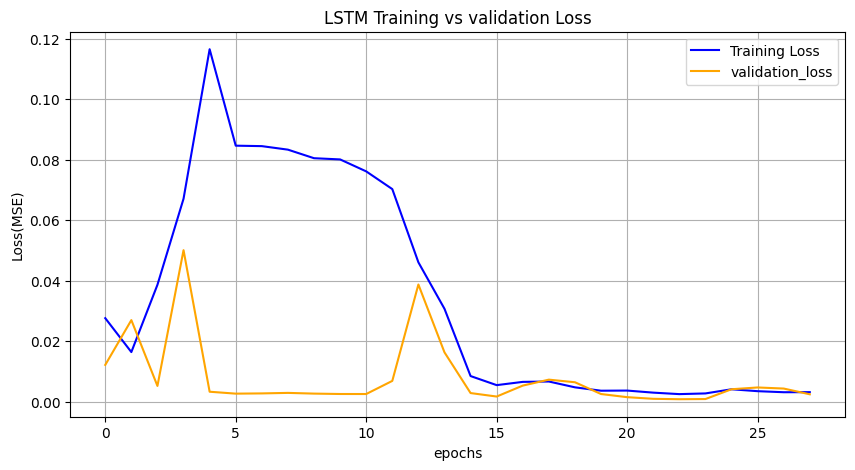

In [23]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label = 'Training Loss',color='blue')
plt.plot(history.history['val_loss'],label = 'validation_loss',color='orange')
plt.title('LSTM Training vs validation Loss')
plt.xlabel("epochs")
plt.ylabel("Loss(MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
df.tail()

,date,open,high,low,close,adj_close,volume,SMA_10,SMA_20,SMA_50,EMA_10,EMA_20,RSI_14,EMA_12,EMA_26,MACD,MACD_signal,return,voliation
2635,2025-11-10,157.115005,159.630005,155.750000,158.880005,158.880005,10493300,166.958002,164.870001,155.945001,162.728765,163.053110,46.591737,163.215329,161.995721,1.219607,3.709270,0.042451,0.036772
2636,2025-11-11,156.830002,160.039993,155.520004,158.940002,158.940002,5344200,164.956001,165.173001,156.343001,162.039899,162.661386,47.188136,162.557586,161.769372,0.788215,3.125059,0.000378,0.036709
2637,2025-11-12,160.110001,160.494003,156.229996,156.589996,156.589996,6585700,162.714001,165.192001,156.670401,161.049008,162.083158,39.946065,161.639495,161.385714,0.253781,2.550803,-0.014785,0.036589
2638,2025-11-13,153.839996,155.000000,143.800003,146.339996,146.339996,11351200,159.987001,164.680500,156.694201,158.374642,160.583809,26.346660,159.285726,160.271217,-0.985490,1.843545,-0.065458,0.035605
2639,2025-11-14,142.330002,149.720001,141.000000,146.039993,146.039993,8379400,157.205000,164.094500,156.678600,156.131979,159.198684,23.346794,157.247921,159.217052,-1.969131,1.081010,-0.002050,0.034298


In [26]:
df_lstm.head()

,close,EMA_12,EMA_26,RSI_14,MACD,voliation
13,2.834,2.626246,2.360847,79.623822,0.265398,0.026275
14,2.810,2.654515,2.394118,78.637762,0.260398,0.026863
15,3.073,2.718898,2.444405,68.942225,0.274492,0.041482
16,3.363,2.817990,2.512449,69.558812,0.305541,0.050130
17,3.550,2.930607,2.589305,70.700630,0.341302,0.044389


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


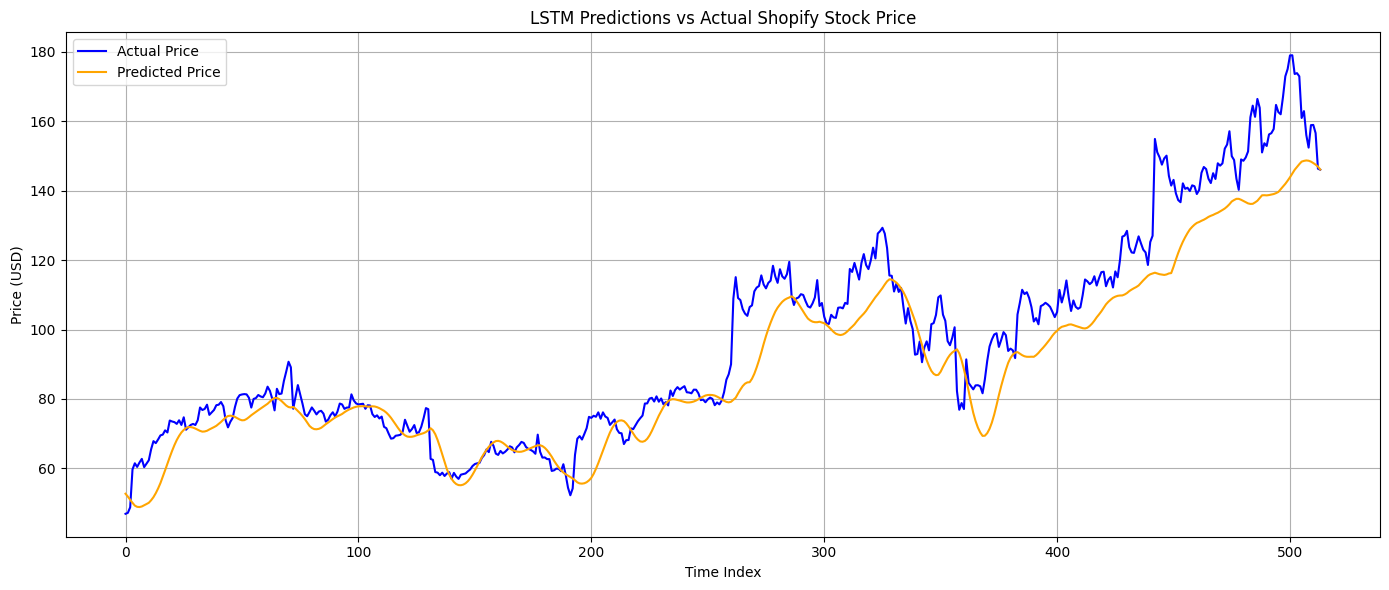

In [35]:
y_pred_scaled = model.predict(X_test)

#Build a DataFrame to inverse transform properly

test_scaled_df = scaled_df.iloc[LOOKBACK+train_size:].copy()

#Replace 'close' col with true test values
true_scaled = test_scaled_df.copy()
true_scaled['close'] = y_test

#Replace 'close' with predictions
pred_scaled = test_scaled_df.copy()
pred_scaled['close'] = y_pred_scaled

#Inverse Transform to real prices 

true_prices = scaler.inverse_transform(true_scaled)[:,0]
pred_prices = scaler.inverse_transform(pred_scaled)[:,0]
plt.figure(figsize=(14,6))
plt.plot(true_prices, label="Actual Price", color='blue')
plt.plot(pred_prices, label="Predicted Price", color='orange')
plt.title("LSTM Predictions vs Actual Shopify Stock Price")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 

In [38]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
rmse


11.445761679683978